We wanted to test ketu on recovering injected planets. So, we injected the 158 known EBs in campaign 0 with planets and attempted to recover them. 

In [236]:
%matplotlib inline
import ketu, sys, pickle, shutil, os
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as pl
from astropy.io import fits, ascii
import remove_EB as remEB
import swarced as sw

In [431]:
path = "/k2_data/c0_known_EB_lc/"
contents = os.listdir(path)
contents = np.array([fn for fn in contents if ("_injected_clip.result" in fn)])
epicid = np.array([fn.split("-")[0][4:] for fn in contents],dtype=np.int32)
ref = ascii.read("/k2_data/c0_EB")

refrows = np.array([list(ref['KIC/EPIC']).index(ind) for ind in epicid])
refsub = ref[refrows]

In [355]:
hdulist = fits.open(path + contents[0].split(".")[0] + ".fits")

In [252]:
list(hdulist[3].data['center'])

[1917.1796, 1963.343]

In [356]:
hdulist[3].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                    2 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'ingress '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'center  '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'egress  '        

In [360]:
hdulist[3].data['ingress']

array([ 1916.88146973,  1963.04504395], dtype=float32)

In [380]:
inj_center, inj_period, inj_rpbyrs, inj_tdepth, inj_tctime, inj_prad, inj_srad, inj_smass, inj_impact = [],[], [], [], [], [], [], [], []
for fn in contents:
    hdulist = fits.open(path + fn.split(".")[0] + ".fits")
    head = hdulist[3].header
    inj_period += [head['PERIOD']]
    inj_rpbyrs += [head['RRATIO']]
    inj_tdepth += [head['TDEPTH']]
    inj_tctime += [head['TCTIME']+hdulist[1].header['BJDREFI']]
    inj_prad += [head['PRADRJ']]
    inj_srad += [head['SRADRS']]
    inj_smass += [head['MSTAR']]
    inj_impact += [head['IMPACT']]
    inj_center += [hdulist[3].data['center'][0] +hdulist[1].header['BJDREFI']]
    hdulist.close()

In [381]:
inj_period, inj_rpbyrs, inj_tdepth=np.array(inj_period), np.array(inj_rpbyrs), np.array(inj_tdepth)                                                   
inj_tctime, inj_prad, inj_srad = np.array(inj_tctime), np.array(inj_prad), np.array(inj_srad)
inj_smass, inj_impact =np.array(inj_smass), np.array(inj_impact)
inj_center = np.array(inj_center)

In [382]:
contents, ref, epicid = np.array(contents), np.array(ref), np.array(epicid)

In [12]:
recovered_period = []
for fn in contents:
    with open(path + fn,'r')as f:
        result = pickle.load(f)
        recovered_period += [result['peaks'][0]['period']]

In [28]:
second_recover = []
for fn in contents:
    with open(path + fn,'r')as f:
        result = pickle.load(f)
        if len(result['peaks']) >= 2:
            second_recover += [result['peaks'][1]['period']]
        else:
            second_recover += [-1.]

In [432]:
eb_period = np.array([row['period'] for row in ref])
recovered_period = np.array(recovered_period)

Below is a schematic of recovery rate. In an ideal world, everything would be on the faint blue line.

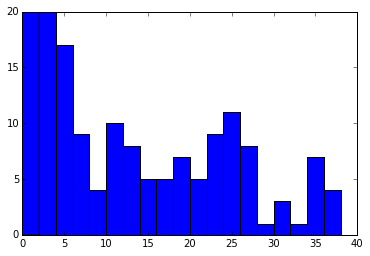

In [89]:
pl.hist(inj_tdepth, np.arange(0,40,2))
pl.show()

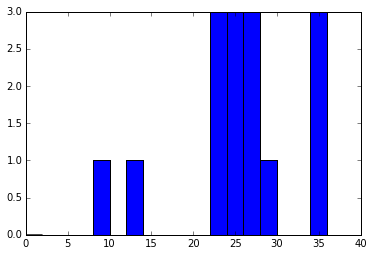

In [90]:
inj_tdepth = np.array(inj_tdepth)
success = np.array(recovered_period)/np.array(expected_period)
pl.hist(inj_tdepth[(success > 0.8) * (success < 1.2)], np.arange(0,40,2))
pl.show()

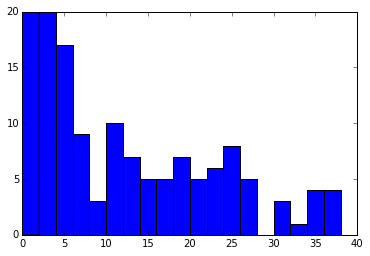

In [91]:
inj_tdepth = np.array(inj_tdepth)
success = np.array(recovered_period)/np.array(expected_period)
pl.hist(inj_tdepth[(success < 0.8) | (success > 1.2)], np.arange(0,40,2))
pl.show()

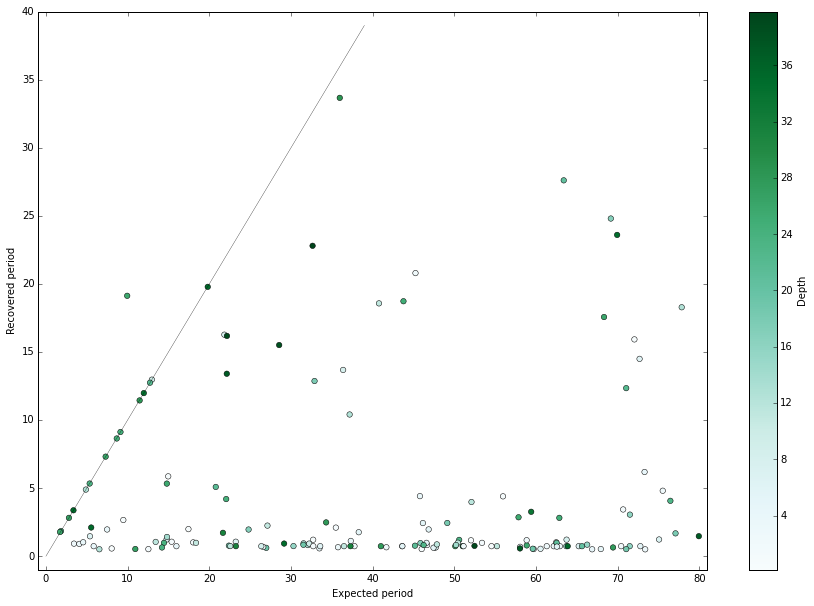

In [187]:
fig = pl.figure(figsize=(15,10))
pl.scatter(inj_period, recovered_period, c=inj_tdepth,cmap='BuGn', lw=0.5, s=30)
pl.colorbar(label= "Depth")
#pl.scatter(expected_period, second_recover, c='red',s=30,lw=0.5)
pl.plot(range(40), 'k',lw=0.3 )
pl.ylabel("Recovered period")
pl.xlabel("Expected period")
pl.xlim(-1,81)
pl.ylim(-1,40)

pl.show()

In [429]:
eb_period

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

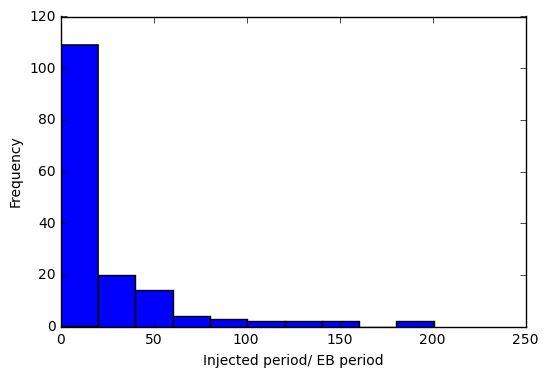

In [443]:
pl.hist(inj_period/eb_period)
pl.xlabel("Injected period/ EB period")
pl.ylabel("Frequency")
pl.show()

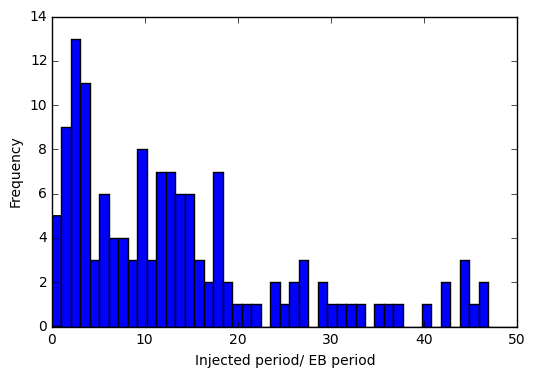

In [442]:
pl.hist(inj_period/eb_period,np.linspace(0,50,50))
pl.xlabel("Injected period/ EB period")
pl.ylabel("Frequency")
pl.show()

I thought maybe we were picking up poorly clipped EBs at the higher end, so I compared that. That doesn't seem to be the case from below

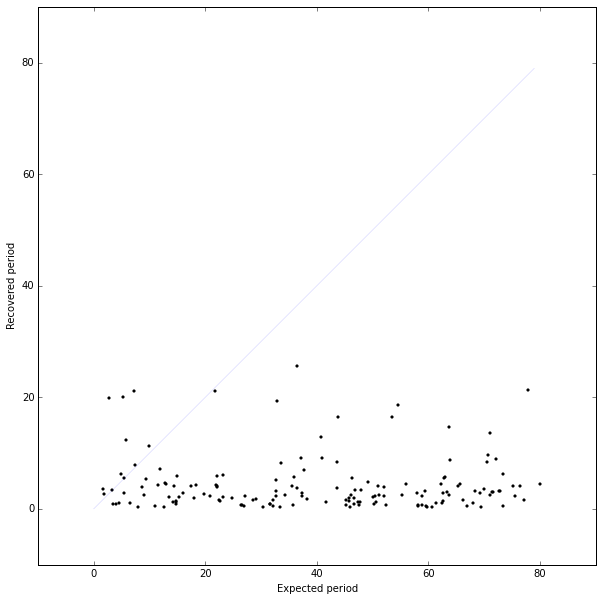

In [54]:
fig = pl.figure(figsize=(10,10))
#pl.scatter(expected_period, recovered_period, c='black',s=10,lw=0)
pl.scatter(expected_period, eb_period, c='black',s=10,lw=0)
pl.plot(range(80), lw=0.1)
pl.ylabel("Recovered period")
pl.xlabel("Expected period")
pl.show()

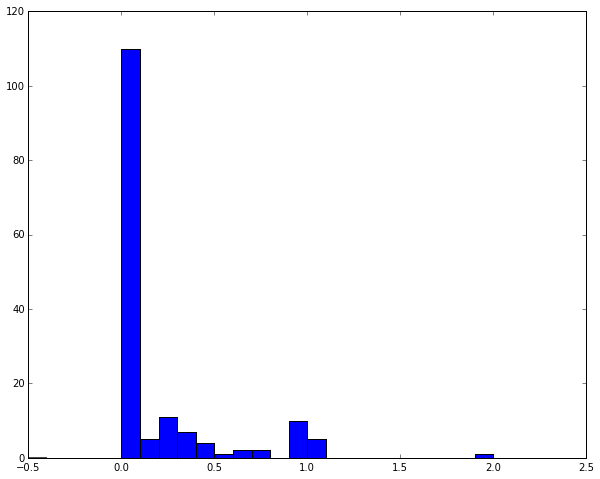

In [46]:
fig = pl.figure(figsize=(10,8))
pl.hist(np.array(recovered_period)/np.array(expected_period), np.arange(-0.5, 2.5, 0.1))
pl.show()

In [ ]:
np.array(recovered_period)/np.array(expected_period),

In [41]:
pct_diff= (np.array(expected_period) - np.array(recovered_period))/(0.5*(np.array(expected_period) + np.array(recovered_period)))

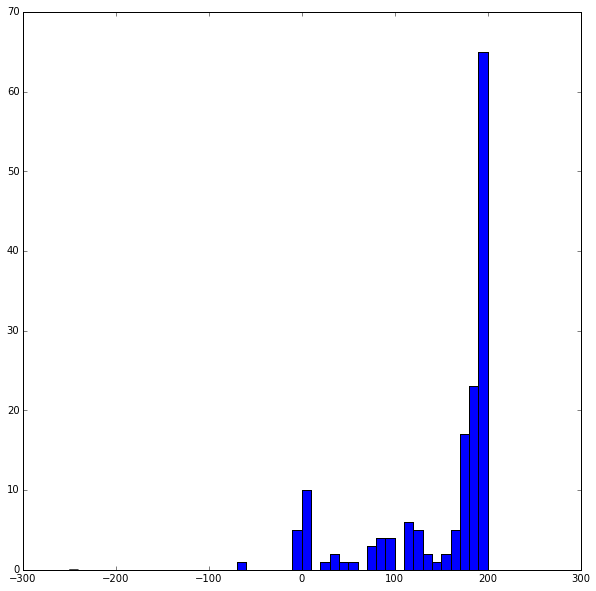

In [49]:
fig = pl.figure(figsize=(10,10))
pl.hist(pct_diff*100, 100*np.arange(-2.5,2.5,0.1))
pl.show()

#Higher Depth Recovery 

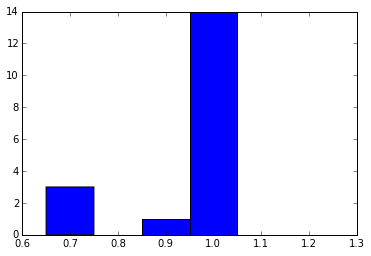

In [143]:
pl.hist(success, np.arange(0.6, 1.3, 0.1)+0.05)
pl.show()

In [145]:
mask = (inj_tdepth > 5) * (success < 0.8)

In [163]:
contents_h, ref_h, epicid_h, eb_period_h = contents[mask], ref[mask], epicid[mask], eb_period[mask]
inj_period_h, inj_rpbyrs_h, inj_tdepth_h, inj_tctime_h = inj_period[mask], inj_rpbyrs[mask], inj_tdepth[mask], inj_tctime[mask] 
inj_prad_h, inj_srad_h, inj_smass_h, inj_impact_h = inj_prad[mask], inj_srad[mask], inj_smass[mask], inj_impact[mask] 

In [164]:
success_h , recovered_period_h= success[mask], recovered_period[mask]

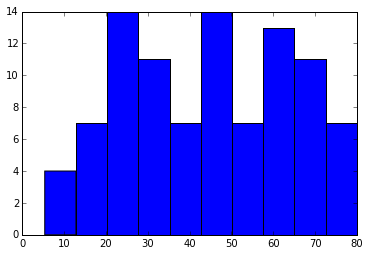

In [148]:
pl.hist(inj_period_h)
pl.show()

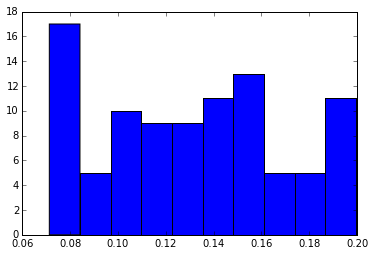

In [149]:
pl.hist(inj_rpbyrs_h)
pl.show()

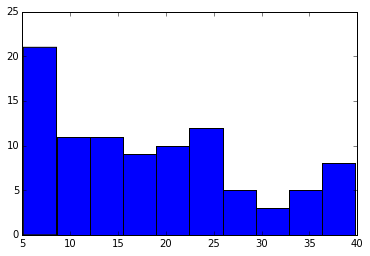

In [150]:
pl.hist(inj_tdepth_h)
pl.show()

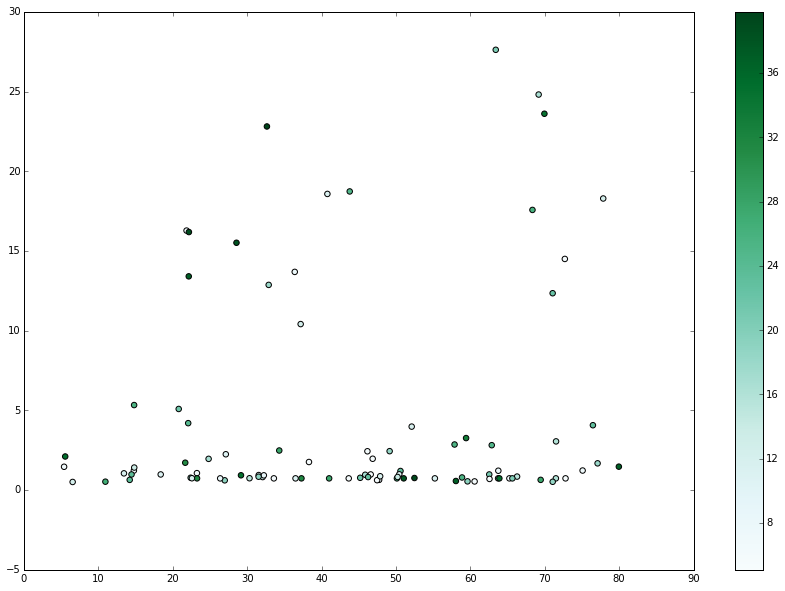

In [178]:
fig = pl.figure(figsize=(15,10))
pl.scatter(inj_period_h, recovered_period_h, c=inj_tdepth_h,s=30,cmap='BuGn')
pl.colorbar()
pl.show()

(array([ 70.,   3.,   3.,   5.,   4.,   4.,   1.,   1.,   1.,   3.]),
 array([ 0.00733308,  0.08108289,  0.1548327 ,  0.22858251,  0.30233232,
         0.37608212,  0.44983193,  0.52358174,  0.59733155,  0.67108136,
         0.74483117]),
 <a list of 10 Patch objects>)

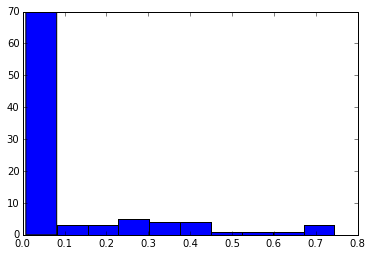

In [179]:
pl.hist(recovered_period_h/inj_period_h)

In [121]:
success_h < 1

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True], dtype=bool)

#Super High Depth Failures 

In [401]:
mask = (inj_tdepth > 20) * ((success < 0.8) | (success > 1.2))
refrows_h = refrows[mask]
contents_h, epicid_h, eb_period_h = contents[mask], epicid[mask], eb_period[mask]
inj_period_h, inj_rpbyrs_h, inj_tdepth_h, inj_tctime_h = inj_period[mask], inj_rpbyrs[mask], inj_tdepth[mask], inj_tctime[mask] 
inj_prad_h, inj_srad_h, inj_smass_h, inj_impact_h = inj_prad[mask], inj_srad[mask], inj_smass[mask], inj_impact[mask]
success_h , recovered_period_h= success[mask], recovered_period[mask]
inj_center_h = inj_center[mask]

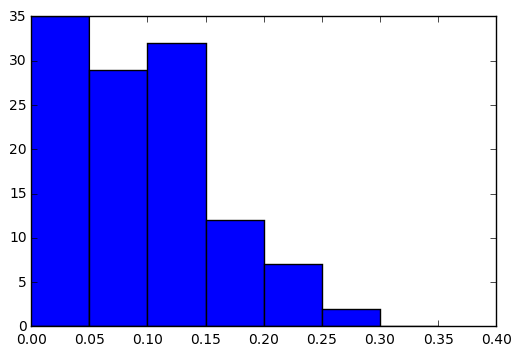

In [396]:
pl.hist(ref[refrows[np.logical_not(mask)]]['pwidth'],np.arange(0,0.4,0.05))
pl.show()

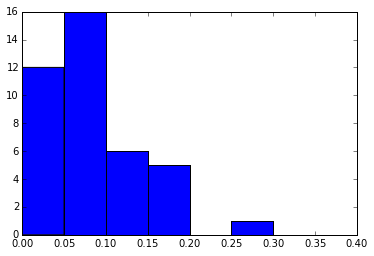

In [233]:
pl.hist(ref[refrows_h]['pwidth'],np.arange(0,0.4,0.05))
pl.show()

In [404]:
epicid_h[i-1]

202073121

In [402]:
i=0

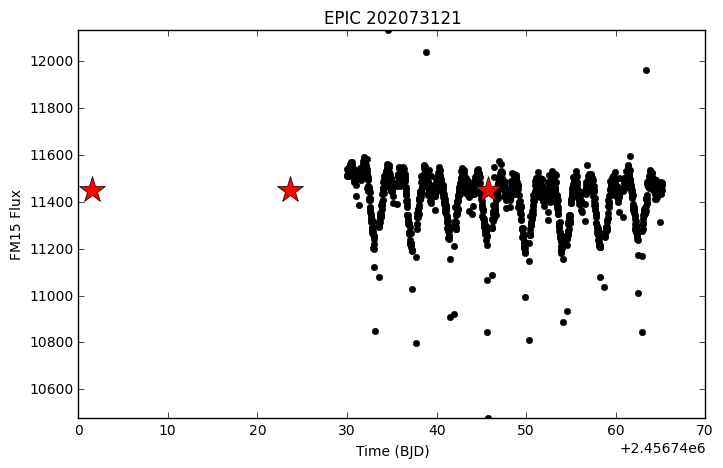

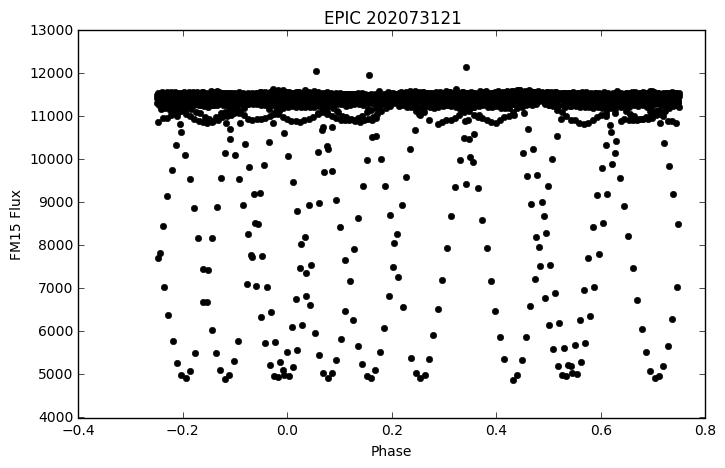

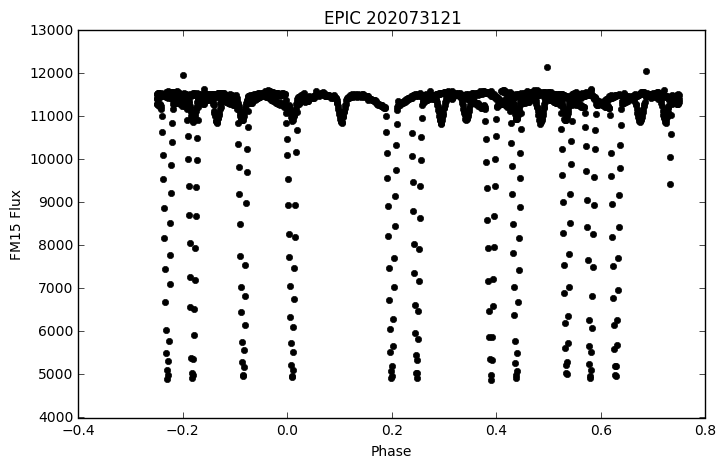

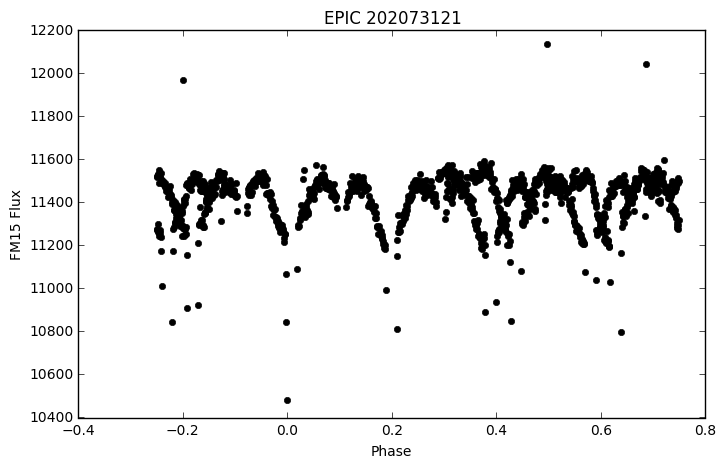

In [403]:
r = ref[refrows[i]]
sw.plot_lc(epicid_h[i], 0,inpath="/k2_data/c0_known_EB_lc/",tail="_injected_clip",injected=True)
sw.plot_phase(epicid_h[i], 0,r['period'], r['bjd0'], inpath="/k2_data/c0_known_EB_lc/",tail="_injected")
sw.plot_phase(epicid_h[i], 0,inj_period_h[i], inj_center_h[i], inpath="/k2_data/c0_known_EB_lc/",tail="_injected")
sw.plot_phase(epicid_h[i], 0,inj_period_h[i], inj_center_h[i], inpath="/k2_data/c0_known_EB_lc/",tail="_injected_clip")
i+=1

#Correct! 

In [415]:
mask = (success > 0.8) * (success < 1.2)
refrows_h = refrows[mask]
contents_h, epicid_h, eb_period_h = contents[mask], epicid[mask], eb_period[mask]
inj_period_h, inj_rpbyrs_h, inj_tdepth_h, inj_tctime_h = inj_period[mask], inj_rpbyrs[mask], inj_tdepth[mask], inj_tctime[mask] 
inj_prad_h, inj_srad_h, inj_smass_h, inj_impact_h = inj_prad[mask], inj_srad[mask], inj_smass[mask], inj_impact[mask]
success_h , recovered_period_h= success[mask], recovered_period[mask]
inj_center_h = inj_center[mask]

In [416]:
i = 0

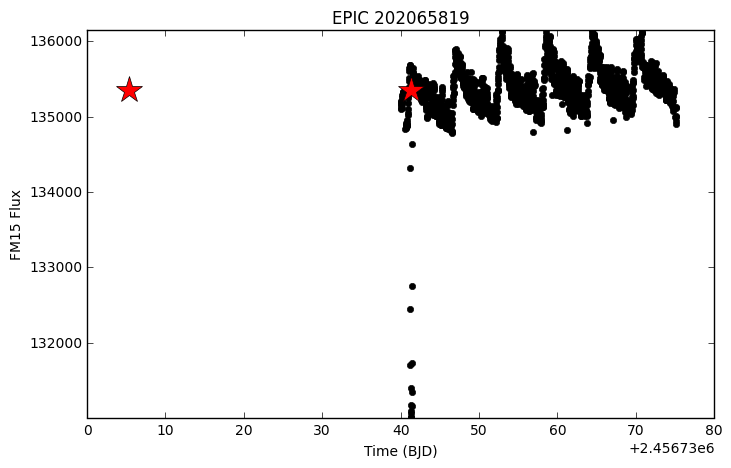

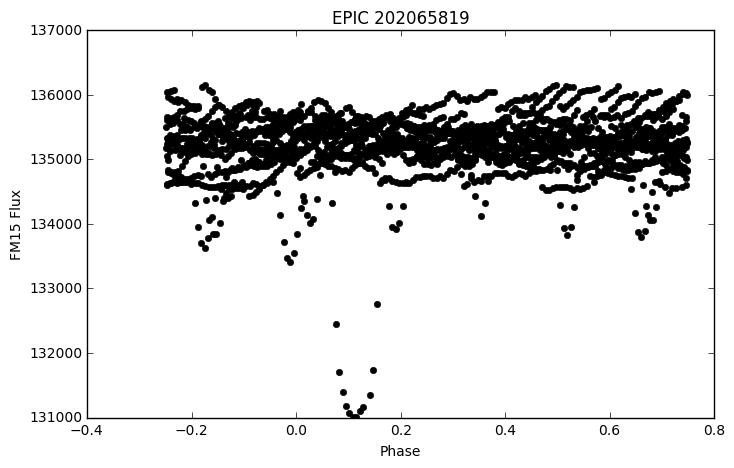

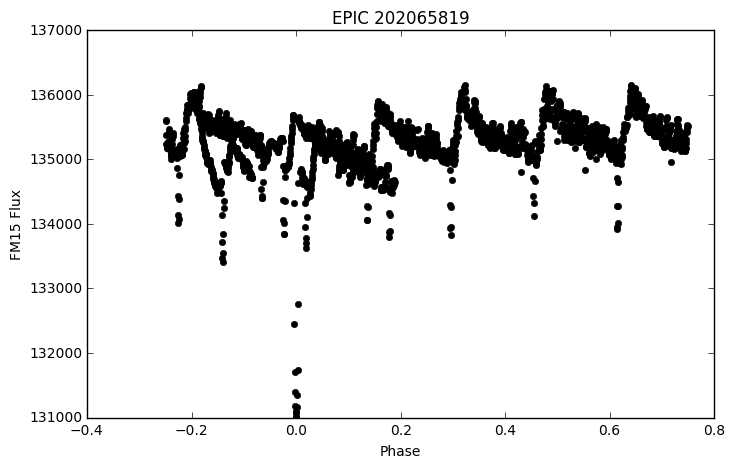

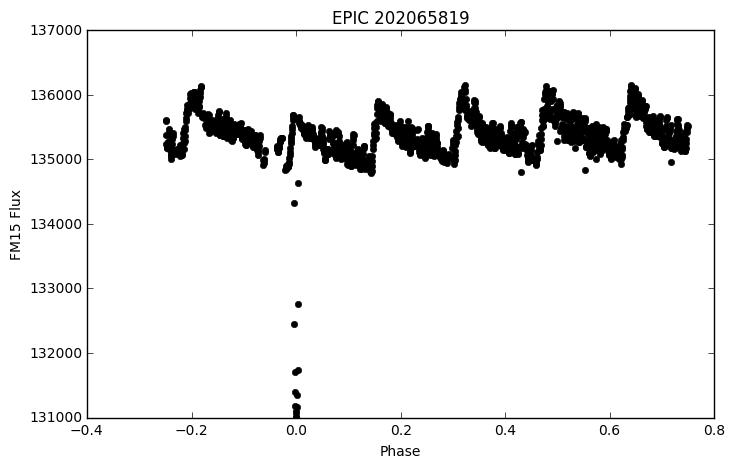

In [427]:
r = ref[refrows[i]]
sw.plot_lc(epicid_h[i], 0,inpath="/k2_data/c0_known_EB_lc/",tail="_injected_clip",injected=True)
sw.plot_phase(epicid_h[i], 0,r['period'], r['bjd0'], inpath="/k2_data/c0_known_EB_lc/",tail="_injected")
sw.plot_phase(epicid_h[i], 0,inj_period_h[i], inj_center_h[i], inpath="/k2_data/c0_known_EB_lc/",tail="_injected")
sw.plot_phase(epicid_h[i], 0,inj_period_h[i], inj_center_h[i], inpath="/k2_data/c0_known_EB_lc/",tail="_injected_clip")
i+=1

#Explore 

In [ ]:
202073121

In [410]:
reload(sw)

<module 'swarced' from 'swarced.py'>

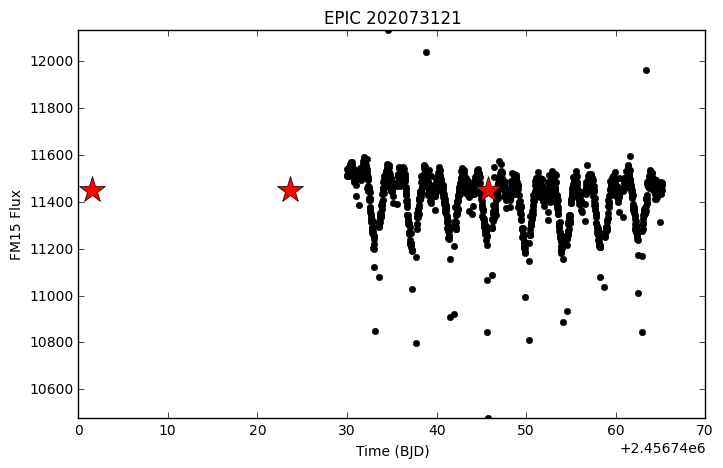

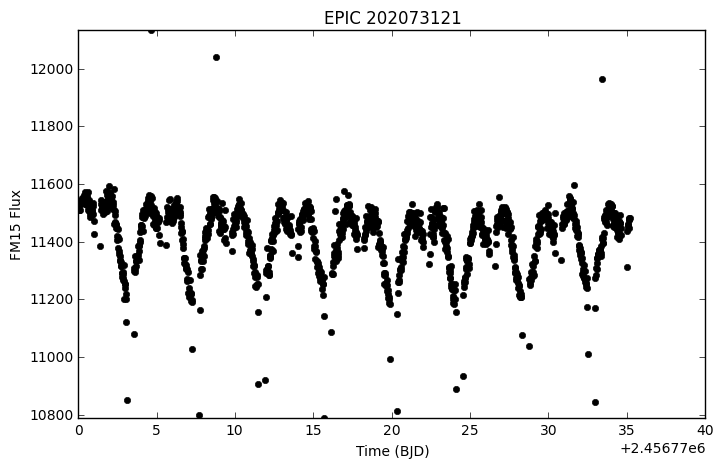

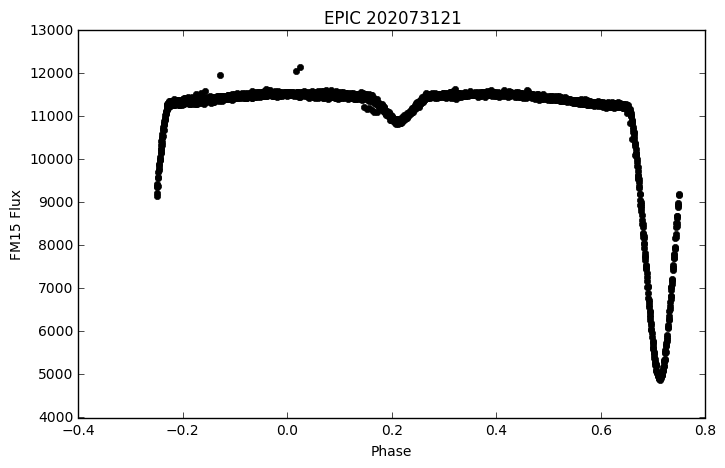

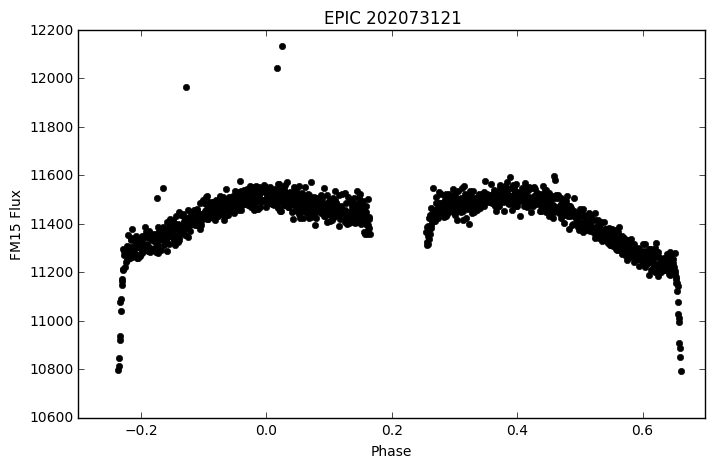

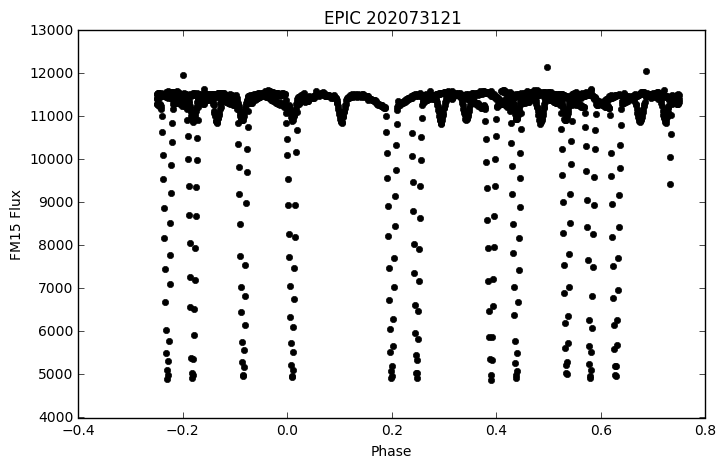

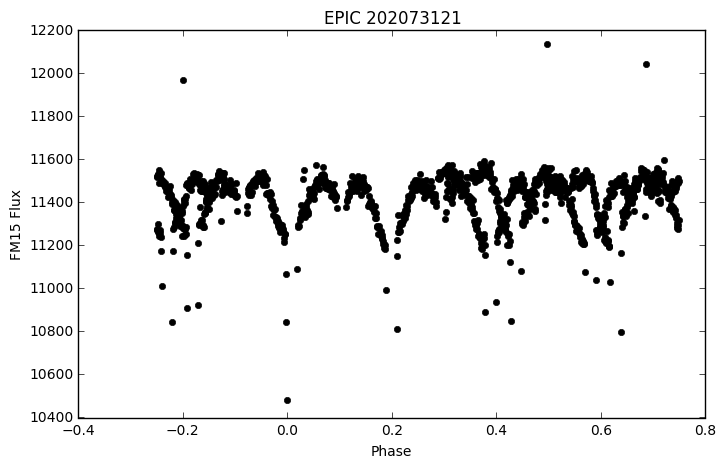

In [412]:
i=np.argmax(epicid == 202073121)
r = ref[refrows[i]]
sw.plot_lc(epicid[i], 0,inpath="/k2_data/c0_known_EB_lc/",tail="_injected_clip",injected=True)
sw.plot_lc(epicid[i], 0,inpath="/k2_data/c0_known_EB_lc/",tail="_clip")
sw.plot_phase(epicid[i], 0,r['period'], r['bjd0'], inpath="/k2_data/c0_known_EB_lc/",tail="_injected")
sw.plot_phase(epicid[i], 0,r['period'], r['bjd0'], inpath="/k2_data/c0_known_EB_lc/",tail="_clip")
sw.plot_phase(epicid[i], 0,inj_period[i], inj_center[i], inpath="/k2_data/c0_known_EB_lc/",tail="_injected")
sw.plot_phase(epicid[i], 0,inj_period[i], inj_center[i], inpath="/k2_data/c0_known_EB_lc/",tail="_injected_clip")